# Creating Message Passing Networks

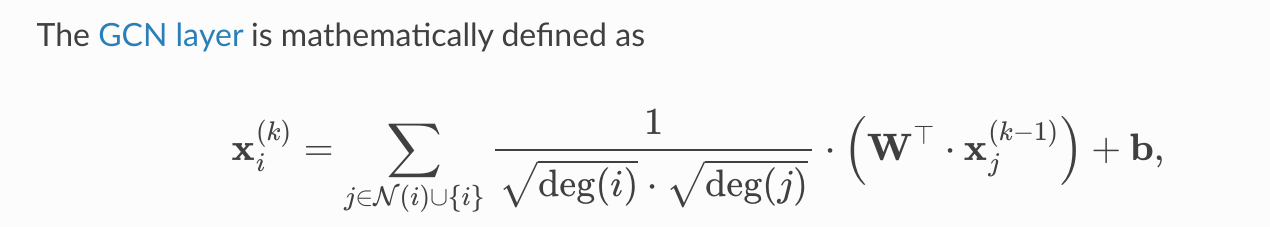

In [1]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))  # edge_index に [0, 0], [1, 1], ... を加えていく

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)  # MessagePassing class の method

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [7]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(len(dataset))

print(data)

1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
x = data.x
edge_index = data.edge_index

conv = GCNConv(1433, 32)
x = conv(x, edge_index)

## GCNConv detail

In [20]:
x = data.x
edge_index = data.edge_index
print(x.shape)
print(edge_index.shape)

torch.Size([2708, 1433])
torch.Size([2, 10556])


In [21]:
edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
print(edge_index.shape)

torch.Size([2, 13264])


In [23]:
x = conv.lin(x)
print(x.shape)

torch.Size([2708, 32])


In [42]:
row, col = edge_index
print(row, col)
deg = degree(col, x.size(0), dtype=x.dtype)
print(deg)
deg_inv_sqrt = deg.pow(-0.5)  # 次数は tail node 側だけを考えている。すなわち incoming node num が次数と定義している。
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

tensor([ 633, 1862, 2582,  ..., 2705, 2706, 2707]) tensor([   0,    0,    0,  ..., 2705, 2706, 2707])
tensor([4., 4., 6.,  ..., 2., 5., 5.])


In [13]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing

class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max') #  "Max" aggregation.
        self.mlp = Seq(Linear(2 * in_channels, out_channels),
                       ReLU(),
                       Linear(out_channels, out_channels))

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        tmp = torch.cat([x_i, x_j - x_i], dim=1)  # tmp has shape [E, 2 * in_channels]
        return self.mlp(tmp)

In [14]:
from torch_geometric.nn import knn_graph

class DynamicEdgeConv(EdgeConv):
    def __init__(self, in_channels, out_channels, k=6):
        super().__init__(in_channels, out_channels)
        self.k = k

    def forward(self, x, batch=None):
        edge_index = knn_graph(x, self.k, batch, loop=False, flow=self.flow)
        return super().forward(x, edge_index)

使い方わからん

In [17]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [15]:
conv = DynamicEdgeConv(3, 128, k=6)
x = conv(x, batch)

NameError: name 'batch' is not defined